In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
file_path = "london_weather.csv"
df = pd.read_csv(file_path)

df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [3]:
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')

features = ['mean_temp', 'min_temp', 'max_temp', 'precipitation', 'cloud_cover', 'sunshine']
df = df[features]

df = df.fillna(method='ffill')

df.head()


/tmp/ipython-input-1917110700.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,mean_temp,min_temp,max_temp,precipitation,cloud_cover,sunshine
0,-4.1,-7.5,2.3,0.4,2.0,7.0
1,-2.6,-7.5,1.6,0.0,6.0,1.7
2,-2.8,-7.2,1.3,0.0,5.0,0.0
3,-2.6,-6.5,-0.3,0.0,8.0,0.0
4,-0.8,-1.4,5.6,0.0,6.0,2.0


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_data.shape

(15341, 6)

In [5]:
SEQ_LENGTH = 7

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # mean_temp index = 0
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LENGTH)

X.shape, y.shape

((15334, 7, 6), (15334,))

In [6]:
train_size = int(0.8 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [8]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [9]:
class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(WeatherRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [10]:
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 1

model = WeatherRNN(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
EPOCHS = 20
losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 0.0061
Epoch [2/20], Loss: 0.0015
Epoch [3/20], Loss: 0.0010
Epoch [4/20], Loss: 0.0009
Epoch [5/20], Loss: 0.0009
Epoch [6/20], Loss: 0.0009
Epoch [7/20], Loss: 0.0009
Epoch [8/20], Loss: 0.0009
Epoch [9/20], Loss: 0.0009
Epoch [10/20], Loss: 0.0009
Epoch [11/20], Loss: 0.0009
Epoch [12/20], Loss: 0.0009
Epoch [13/20], Loss: 0.0009
Epoch [14/20], Loss: 0.0009
Epoch [15/20], Loss: 0.0009
Epoch [16/20], Loss: 0.0009
Epoch [17/20], Loss: 0.0009
Epoch [18/20], Loss: 0.0009
Epoch [19/20], Loss: 0.0009
Epoch [20/20], Loss: 0.0009


In [12]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.extend(outputs.numpy())
        actuals.extend(y_batch.numpy())

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(actuals, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0010471975881551757


In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.024790849567023248


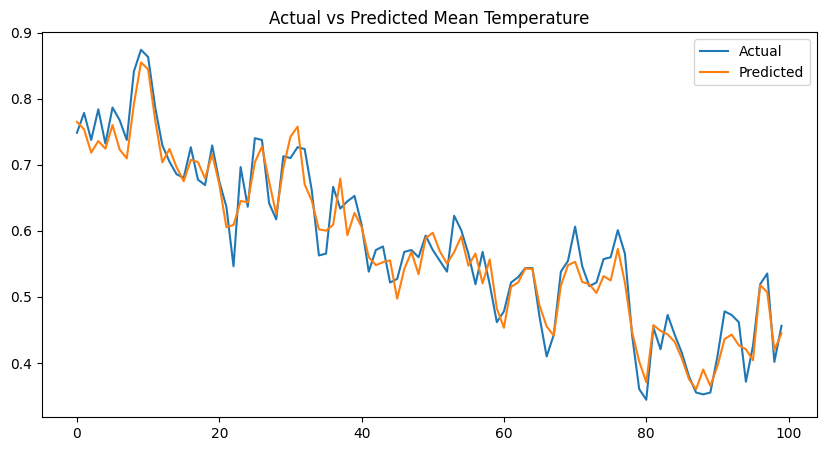

In [13]:
plt.figure(figsize=(10,5))
plt.plot(actuals[:100], label="Actual")
plt.plot(predictions[:100], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Mean Temperature")
plt.show()

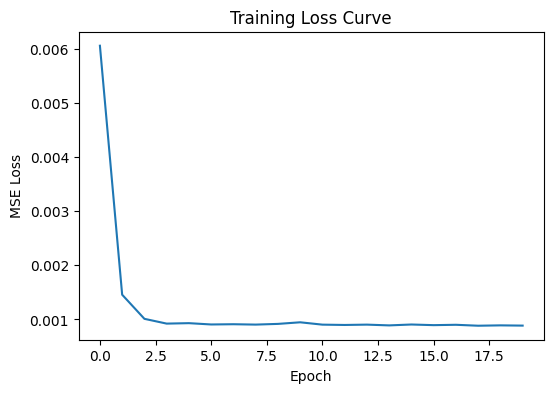

In [14]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [18]:
def predict_next_day(model, last_sequence):
    model.eval()
    with torch.no_grad():
        last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
        prediction = model(last_sequence)
    return prediction.item()

In [19]:
last_7_days = X_test[-1]
next_day_scaled = predict_next_day(model, last_7_days)

temp_array = np.zeros((1, scaled_data.shape[1]))
temp_array[0, 0] = next_day_scaled

next_day_temp = scaler.inverse_transform(temp_array)[0, 0]

print("Predicted Next Day Mean Temperature (°C):", next_day_temp)

Predicted Next Day Mean Temperature (°C): 3.192199063301087


/tmp/ipython-input-23210043.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)
